In [1]:
import os
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
from matmul import linear_estimates, logit_estimates, attend_estimates, fused_logit_softmax_dpr_attend_estimates
from norm import layer_norm_estimates
from pointwise import softmax_estimates, dropout_estimates, nonlinear_act_estimates
from time_projections import get_time_flops, get_time_mem, get_time_comm, get_topology, get_total_time

In [3]:
def compute_timings_and_stats(summary, system):
    ''' timings, any other df stats '''

    # which layers use tensor cores
    tensor_core_layers = ['fc1', 'fc2', 'qkv_proj', 'v_proj', 'logits', 'attend']
   
    # time for forward
    summary['t_comp_fwd'] = summary.apply(lambda x: get_time_flops(x["flops_fwd"], 
                                                                   use_tensor=(x["layer"] in tensor_core_layers),
                                                                   system=system), axis=1)
    summary['t_mem_fwd'] = summary.apply(lambda x: get_time_mem(x["total_mem_fwd"], system=system), axis=1)
    # time for backward
    summary['t_comp_bwd'] = summary.apply(lambda x: get_time_flops(x["flops_bwd"], 
                                                                   use_tensor=(x["layer"] in tensor_core_layers),
                                                                   system=system), axis=1)
    summary['t_mem_bwd'] = summary.apply(lambda x: get_time_mem(x["total_mem_bwd"], system=system), axis=1)
    
    # times
    summary['intensity'] = summary['t_comp_fwd'] / summary['t_mem_fwd']
    # roofline
    summary['t_fwd'] = summary.apply(lambda x: max(x['t_comp_fwd'], x['t_mem_fwd']), axis=1)
    summary['t_bwd'] = summary.apply(lambda x: max(x['t_comp_bwd'], x['t_mem_bwd']), axis=1)
    
    # time for communication
    use_empirical = False
    summary['comm_topology'] = summary.apply(lambda x: get_topology(x["comm_size"], system=system), axis=1)
    summary['t_comm_fwd'] = summary.apply(lambda x: get_time_comm(x["comm_fwd"],
                                                                  n_gpuss=x["comm_size"],
                                                                  comm_types=x["comm_fwd_type"], 
                                                                  topologys=x["comm_topology"],
                                                                  empirical=use_empirical,
                                                                  system=system), axis=1)
    summary['t_comm_bwd'] = summary.apply(lambda x: get_time_comm(x["comm_bwd"],
                                                                  n_gpuss=x["comm_size"],
                                                                  comm_types=x["comm_bwd_type"], 
                                                                  topologys=x["comm_topology"],
                                                                  empirical=use_empirical,
                                                                  system=system), axis=1)
    
    # total time
    summary['t_total_fwd'] = summary.apply(lambda x: get_total_time(x['t_fwd'], x['t_comm_fwd'], use_max=False), axis=1)
    summary['t_total_bwd'] = summary.apply(lambda x: get_total_time(x['t_bwd'], x['t_comm_bwd'], use_max=False), axis=1)
    
    # fraction
    summary['frac_t_comm_fwd'] = summary['t_comm_fwd'] / summary['t_total_fwd']
    summary['frac_t_comm_bwd'] = summary['t_comm_bwd'] / summary['t_total_bwd']

    return summary

In [4]:
#### nn modules ###
def MLP_estimates(b, l, e, f, depth, element_size=4E-6, mask_element_size=1E-6, flops_units=1E-12, parallelism={'m1': 1, 'm2': 1}, system={}):
    """
    MLP layer estimates
    parameters: b: batch size
                l: seq length
                e: embedding dim
                f: hidden dim
                element_size: in MB
                mask_element_size: in MB (for dropout)
    
    tensor shapes: input tensor: (b,l,e)
                   output tensor: (b,l,e)
                   
    layer arithmetic: 
        forward pass: 
             X = XW + b
             (b,l,f) = (b,l,e) * (e,f) + (1,f)
             X = nonlinear(X)
             (b,l,f) = (b,l,f)
             X = dropout(X)
             (b,l,f) = (b,l,f) * (b,l,f) [random mask]
             X = linear(X)
             (b,l,e) = (b,l,f) * (f,e) + (1,e)
             X = dropout(X)
             (b,l,e) = (b,l,e) * (b,l,e) [random mask]
            
        backward pass:
             chain rule
             
    parallelism:
            X = XW + b
            (b,l,f/m) = (b,l,e) * (e,f/m) + (1,f/m)
            X = nonlinear(X)
            (b,l,f/m) = (b,l,f/m)
            X = dropout(X)
            (b,l,f/m) = (b,l,f/m) * (b,l,f/m) [random mask]
            X = linear(X)
            (b,l,e/m) = (b,l,f/m) * (f/m,e) + (1,e)
            X = dropout(X)
            (b,l,e) = (b,l,e) * (b,l,e) [random mask]
            
    comments: 
    """
    
    summary = []
    
    m1 = parallelism['m1']
    m2 = 1 # parallelism['m2'] # not used in 1D parallelism (set to 1)
    
    m1_parallel = (m1 > 1)
    
    total_time = 0
    
    ######################################################################################################################################################
    ######################################################################################################################################################
        
    stats = linear_estimates(b, l, e, f // m1, element_size=element_size, has_bias=True, flops_units=flops_units)
    stats["layer"] = "fc1"   
    # sync/comm layers
    # no fwd comms
    stats["comm_bwd"] = m1_parallel * (b * l * e) * element_size # bwd comms for partial sums of b,l,e
    stats["comm_bwd_type"] = "reducescatter" 
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = nonlinear_act_estimates(b, l, f // m1, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "act"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l, f // m1, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dpr1"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = linear_estimates(b, l, f // m1, e, element_size=element_size, has_bias=True, flops_units=flops_units)
    stats["layer"] = "fc2"
    # sync/comm layers
    # no bwd comms
    stats["comm_fwd"] =  m1_parallel * (b * l * e) * element_size # fwd comms for partial sums of b,l,e
    stats["comm_fwd_type"] = "reducescatter"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l // m1, e, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dpr2"
    # sync/comm layers
    stats["comm_bwd"] = m1_parallel *  (b * l * e) * element_size
    stats["comm_bwd_type"] = "allgather"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    summary = pd.DataFrame(summary)
    summary = compute_timings_and_stats(summary, system)
    
    return summary
        

In [5]:
def self_attention_estimates(b, l, e, h, element_size=4E-6, mask_element_size=1E-6, flops_units=1E-12, flash_attention=True, parallelism={'m1': 1, 'm2': 1}, system={}):
    """
    dropout layer estimates
    parameters: b: batch size
                l: seq length
                e: embedding dim/hidden dim
                h: number of attention heads
                element_size: in MB
    
    tensor shapes: input tensor: (b,l,e)
                   output tensor: (b,l,e)
                   
    layer arithmetic: 
        define: q = e/h
        forward pass: 
             X = norm(X)
             Q = XW, K = XW, V = XW
             (b,l,h,q,3) = (b,l,e) * (e,3hq)
             A = QK'/sqrt(q)
             (b,h,l,l) = (b,h,l,q) * (b,h,q,l)
             A = softmax(A)
             (b,h,l,l) = (b,h,l,l)
             A = dpr(A)
             Y = AV
             (b,h,l,q) = (b,h,l,l) * (b,h,l,q)
             Y = VW
             (b,l,e) = (b,l,hq) * (hq,e)
             Y = dpr(Y)
             (b,l,e) = (b,l,e)
             Y = norm(Y)
             (b,l,e) = (b,l,e)
             
        backward pass:
             chain rule
             
        parallelism:
             X = norm(X)
             Q = XW, K = XW, V = XW
             (b,l,h/m,q,3) = (b,l,e) * (e,3hq/m)
             A = QK'/sqrt(q)
             (b,h/m,l,l) = (b,h/m,l,q) * (b,h/m,q,l)
             A = softmax(A)
             (b,h/m,l,l) = (b,h/m,l,l)
             A = dpr(A)
             (b,h/m,l,l) = (b,h/m,l,l)
             Y = AV
             (b,h/m,l,q) = (b,h/m,l,l) * (b,h/m,l,q)
             Y = VW
             (b,l,e) = (b,l,hq/m) * (hq/m,e)
             Y = dpr(Y)
             (b,l,e) = (b,l,e)
             Y = norm(Y)
             (b,l,e) = (b,l,e)
            
    
    comments: 
    """
    summary = []
    
    q = e // h
    
    m1 = parallelism['m1']
    m2 = 1 #parallelism['m2'] # 1D parallelism for now
    
    m1_parallel = (m1 > 1)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = layer_norm_estimates(b, l // m1, e, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "layer_norm_1"
    # sync/comm layers
    stats["comm_fwd"] = m1_parallel * (b * l * e) * element_size # all gather for the next op
    stats["comm_fwd_type"] = "allgather"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = linear_estimates(b, l, e, (3*e) // m1, element_size=element_size, has_bias=False, flops_units=flops_units)
    stats["layer"] = "qkv_proj"
    # sync/comm layers: no fwd coms here
    stats["comm_bwd"] = m1_parallel * (b * l * e) * element_size # reduce scatter before going to ln: TODO check?
    stats["comm_bwd_type"] = "reducescatter"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    if flash_attention:
        stats = fused_logit_softmax_dpr_attend_estimates(b, l, q, h // m1, element_size=element_size, flops_units=flops_units)
        stats["layer"] = "fused_la"
        summary.append(stats)
    else:
        stats = logit_estimates(b, l, q, h // m1, element_size=element_size, flops_units=flops_units)
        stats["layer"] = "logits"
        summary.append(stats)
        ######################################################################################################################################################
        ######################################################################################################################################################

        stats = softmax_estimates(b, l, l, h // m1, element_size=element_size, flops_units=flops_units)
        stats["layer"] = "softmax"
        summary.append(stats)

        ######################################################################################################################################################
        ######################################################################################################################################################

        stats = dropout_estimates(b, l, (l*h) // m1, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
        stats["layer"] = "dropout_softmax"
        summary.append(stats)

        ######################################################################################################################################################
        ######################################################################################################################################################

        stats = attend_estimates(b, l, q, h // m1, element_size=element_size, flops_units=flops_units)
        stats["layer"] = "attend"
        summary.append(stats)    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = linear_estimates(b, l, (h*q) // m1, e, element_size=element_size, has_bias=True, flops_units=flops_units)
    stats["layer"] = "v_proj"
    # sync/comm layers
    stats["comm_fwd"] = m1_parallel * (b * l * e) * element_size # fwd comms for partial sums of b,l,e
    stats["comm_fwd_type"] = "reducescatter"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l // m1, e, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dropout"
    # sync/comm layers
    stats["comm_bwd"] = m1_parallel * (b * l * e) * element_size
    stats["comm_bwd_type"] = "allgather"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = layer_norm_estimates(b, l // m1, e, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "layer_norm_2"
    # sync/comm layers
    stats["comm_fwd"] = m1_parallel * (b * l * e) * element_size # all gather for the next op
    stats["comm_fwd_type"] = "allgather"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    summary = pd.DataFrame(summary)
    summary = compute_timings_and_stats(summary, system)

    
    return summary

In [6]:
### model
pd.options.display.max_columns = None
pd.options.display.max_rows = None
b = 1
patch = 16
ih = 720
iw = 1440

gpt2 = {'l': 1024, 'e': 1600, 'h': 12, 'depth': 48}
gpt3 = {'l': 2048, 'e': 12288, 'h': 96, 'depth': 96}
gpt3_lowdepth = {'l': 2048, 'e': 12288, 'h': 96, 'depth': 96 // 8}
vit_era5 = {'l': 16200, 'e': 2048, 'h': 16, 'depth': 24}

model = gpt2
l = model['l']
e = model['e']
f = 4 * e
h = model['h']
depth = model['depth']
fp32_sz = 4E-9
fp16_sz = 2E-9
int_sz = 1E-9
flops_units = 1E-12 # teraflops

print("model: batch size = {}, seq length = {}, embed = {}, attention heads = {}, depth = {}".format(b, l, e, h, depth))

### model parallelism
parallelism = {'m1': 16,
               'm2': 1}
### system configs
system = {'matrix_flops_fp16': 312,
          'vector_flops_fp32': 19.5,
          'vector_flops_fp16': 78,
          'hbm_bandwidth': 1555,
          'nvlink_bandwidth': 300,
          'ib_bandwidth': 100,
          'nvlink_size': 4}
print("parallelization: m1 = {}, m2 = {}".format(parallelism['m1'], parallelism['m2']))

# MLP
df_mlp = MLP_estimates(b, l, e, f, depth, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
                       parallelism=parallelism, system=system)
cols = df_mlp.columns.tolist()
cols.remove('layer')
cols = ['layer'] + cols

# self attention
df_sa = self_attention_estimates(b, l, e, h, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
                                 flash_attention=False, parallelism=parallelism, system=system)

# sum these columns (mem in buffer: activation buffers, weights, weights_grads, total flops, timings)
layer_track_cols = ['activation_buffer', 'weights_mem', 
                    'weights_grad_mem', 'flops_fwd', 'flops_bwd', 
                    't_total_fwd', 't_total_bwd', 't_comm_fwd', 't_comm_bwd']

print('\n************** MLP layer estimates **************\n')
display(df_mlp[cols])
display(df_mlp[layer_track_cols].sum() * depth)
t_f = df_mlp['t_total_fwd'].sum()
t_c = df_mlp['t_comm_fwd'].sum()
print('time spend in comms = {}'.format(t_c / t_f))

print('\n************** SA layer estimates **************\n')
display(df_sa[cols])
display(df_sa[layer_track_cols].sum() * depth)
t_f = df_sa['t_total_fwd'].sum()
t_c = df_sa['t_comm_fwd'].sum()
print('time spend in comms = {}'.format(t_c / t_f))

print('\n************** Training estimates **************\n')
t_itr = (df_mlp['t_total_fwd'].sum() + df_mlp['t_total_bwd'].sum() + df_sa['t_total_fwd'].sum() + df_sa['t_total_bwd'].sum()) * depth
print('time for 1 itr = {}'.format(t_itr))

f1 = 3 # 1 fp16 wt, 1 fp32 copy
f2 = 5 # 1 pfp16 grad, 2 fp32 means and variances
mem = (df_mlp['weights_mem'].sum() * f1 + df_mlp['weights_grad_mem'].sum() * f2 + df_mlp['activation_buffer'].sum() +
       df_sa['weights_mem'].sum() * f1 + df_sa['weights_grad_mem'].sum() * f2 + df_sa['activation_buffer'].sum()) * depth
print('mem consumed = {}'.format(mem))

model: batch size = 1, seq length = 1024, embed = 1600, attention heads = 12, depth = 48
parallelization: m1 = 16, m2 = 1

************** MLP layer estimates **************



,layer,flops_fwd,activation_buffer,weights_mem,total_mem_fwd,flops_bwd,weights_grad_mem,total_mem_bwd,comm_bwd,comm_bwd_type,comm_size,comm_fwd,comm_fwd_type,t_comp_fwd,t_mem_fwd,t_comp_bwd,t_mem_bwd,intensity,t_fwd,t_bwd,comm_topology,t_comm_fwd,t_comm_bwd,t_total_fwd,t_total_bwd,frac_t_comm_fwd,frac_t_comm_bwd
0,fc1,1.310720e-03,0.003277,0.001281,0.005377,2.619571e-03,0.001281,0.011573,0.003277,reducescatter,16.0,NaN,NaN,0.004201,0.003458,0.008396,0.007442,1.214960,0.004201,0.008396,ib,0.000000,0.032768,0.004201,0.041164,0.000000,0.796034
1,act,4.096000e-07,0.000819,0.000000,0.001638,4.096000e-07,0.000000,0.002458,NaN,NaN,NaN,NaN,NaN,0.000005,0.001054,0.000005,0.001580,0.004984,0.001054,0.001580,None,0.000000,0.000000,0.001054,0.001580,0.000000,0.000000
2,dpr1,4.096000e-07,0.000410,0.000000,0.002048,4.096000e-07,0.000000,0.002048,NaN,NaN,NaN,NaN,NaN,0.000005,0.001317,0.000005,0.001317,0.003987,0.001317,0.001317,None,0.000000,0.000000,0.001317,0.001317,0.000000,0.000000
3,fc2,1.310720e-03,0.000819,0.001283,0.005379,2.622029e-03,0.001283,0.014035,NaN,NaN,16.0,0.003277,reducescatter,0.004201,0.003459,0.008404,0.009026,1.214418,0.004201,0.009026,ib,0.032768,0.000000,0.036969,0.009026,0.886364,0.000000
4,dpr2,1.024000e-07,0.000102,0.000000,0.000512,1.024000e-07,0.000000,0.000512,0.003277,allgather,16.0,NaN,NaN,0.000001,0.000329,0.000001,0.000329,0.003987,0.000329,0.000329,ib,0.000000,0.032768,0.000329,0.033097,0.000000,0.990052


activation_buffer    0.260506
weights_mem          0.123072
weights_grad_mem     0.123072
flops_fwd            0.125873
flops_bwd            0.251641
t_total_fwd          2.105759
t_total_bwd          4.136864
t_comm_fwd           1.572864
t_comm_bwd           3.145728
dtype: float64

time spend in comms = 0.7469343453393582

************** SA layer estimates **************



,layer,flops_fwd,activation_buffer,weights_mem,total_mem_fwd,flops_bwd,weights_grad_mem,total_mem_bwd,comm_bwd,comm_bwd_type,comm_size,comm_fwd,comm_fwd_type,t_comp_fwd,t_mem_fwd,t_comp_bwd,t_mem_bwd,intensity,t_fwd,t_bwd,comm_topology,t_comm_fwd,t_comm_bwd,t_total_fwd,t_total_bwd,frac_t_comm_fwd,frac_t_comm_bwd
0,layer_norm_1,9.216000e-07,0.000205,0.000006,0.000416,1.228544e-06,0.000006,0.001030,NaN,NaN,16.0,0.003277,allgather,0.000012,0.000268,0.000016,0.000663,0.044139,0.000268,0.000663,ib,0.032768,0.000000,0.033036,0.000663,0.991897,0.000000
1,qkv_proj,9.827328e-04,0.003277,0.000960,0.004851,1.963962e-03,0.000960,0.009702,0.003277,reducescatter,16.0,NaN,NaN,0.003150,0.003120,0.006295,0.006239,1.009630,0.003150,0.006295,ib,0.000000,0.032768,0.003150,0.039063,0.000000,0.838855
2,logits,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,NaN,NaN
3,softmax,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,NaN,NaN
4,dropout_softmax,7.864320e-07,0.000786,0.000000,0.003932,7.864320e-07,0.000000,0.003932,NaN,NaN,NaN,NaN,NaN,0.000010,0.002529,0.000010,0.002529,0.003987,0.002529,0.002529,None,0.000000,0.000000,0.002529,0.002529,0.000000,0.000000
5,attend,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,NaN,NaN
6,v_proj,3.244032e-04,0.000203,0.000320,0.003800,6.501850e-04,0.000320,0.010876,NaN,NaN,16.0,0.003277,reducescatter,0.001040,0.002443,0.002084,0.006994,0.425528,0.002443,0.006994,ib,0.032768,0.000000,0.035211,0.006994,0.930607,0.000000
7,dropout,1.024000e-07,0.000102,0.000000,0.000512,1.024000e-07,0.000000,0.000512,0.003277,allgather,16.0,NaN,NaN,0.000001,0.000329,0.000001,0.000329,0.003987,0.000329,0.000329,ib,0.000000,0.032768,0.000329,0.033097,0.000000,0.990052
8,layer_norm_2,9.216000e-07,0.000205,0.000006,0.000416,1.228544e-06,0.000006,0.001030,NaN,NaN,16.0,0.003277,allgather,0.000012,0.000268,0.000016,0.000663,0.044139,0.000268,0.000663,ib,0.032768,0.000000,0.033036,0.000663,0.991897,0.000000


activation_buffer    0.229343
weights_mem          0.062054
weights_grad_mem     0.062054
flops_fwd            0.062874
flops_bwd            0.125640
t_total_fwd          5.149948
t_total_bwd          3.984391
t_comm_fwd           4.718592
t_comm_bwd           3.145728
dtype: float64

time spend in comms = 0.9162406967246964

************** Training estimates **************

time for 1 itr = 15.37696276072224
mem consumed = 1.970860032


In [7]:
def plot(n_gpus, parallelism, system, axs, lgnd=['MLP', 'SA'], lgnd_tot=['nvlink1'], lfmt="-"):
    t_frac_mlp = []
    t_frac_sa = []

    t_mlp_c = []
    t_sa_c = []

    t_mlp_comm = []
    t_sa_comm = []
    
    t_itr = []

    for n in n_gpus:
        parallelism['m1'] = n
        parallelism['m2'] = 1

        df_mlp = MLP_estimates(b, l, e, f, depth, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
                               parallelism=parallelism, system=system)
        df_sa = self_attention_estimates(b, l, e, h, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
                                         flash_attention=True, parallelism=parallelism, system=system)
        t_f = df_mlp['t_total_fwd'].sum()* depth
        t_c = df_mlp['t_comm_fwd'].sum()* depth
        t_mlp_c.append(t_f)
        t_mlp_comm.append(t_c)
        t_frac_mlp.append(t_c / t_f)

        t_f = df_sa['t_total_fwd'].sum()* depth
        t_c = df_sa['t_comm_fwd'].sum()* depth
        t_sa_c.append(t_f)
        t_sa_comm.append(t_c)
        t_frac_sa.append(t_c / t_f)
        
        t_itr.append((df_mlp['t_total_fwd'].sum() + df_mlp['t_total_bwd'].sum() + df_sa['t_total_fwd'].sum() + df_sa['t_total_bwd'].sum()) * depth)


    ax = axs[0]
    ax.plot(n_gpus, t_frac_mlp, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_frac_sa, lfmt, linewidth=2, c=c2)
    # ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Fraction of time in comms', fontsize=fsz)
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize=fsz-4)
    ax.legend(lgnd, fontsize=fsz-4)


    ax = axs[1]
    ax.plot(n_gpus, t_mlp_c, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_sa_c, lfmt, linewidth=2, c=c2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Total fwd time', fontsize=fsz)
    
    ax.legend(lgnd, fontsize=fsz-4)
    
    ax = axs[2]
    ax.plot(n_gpus, t_itr, lfmt, linewidth=2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Total time', fontsize=fsz)
    # ax.set_yticks(list(np.arange(0,2000,100)))
    # ax.set_yticklabels(list(np.arange(0,2000,100)), fontsize=fsz-4)
    ax.legend(lgnd_tot, fontsize=fsz-4)
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%d"))

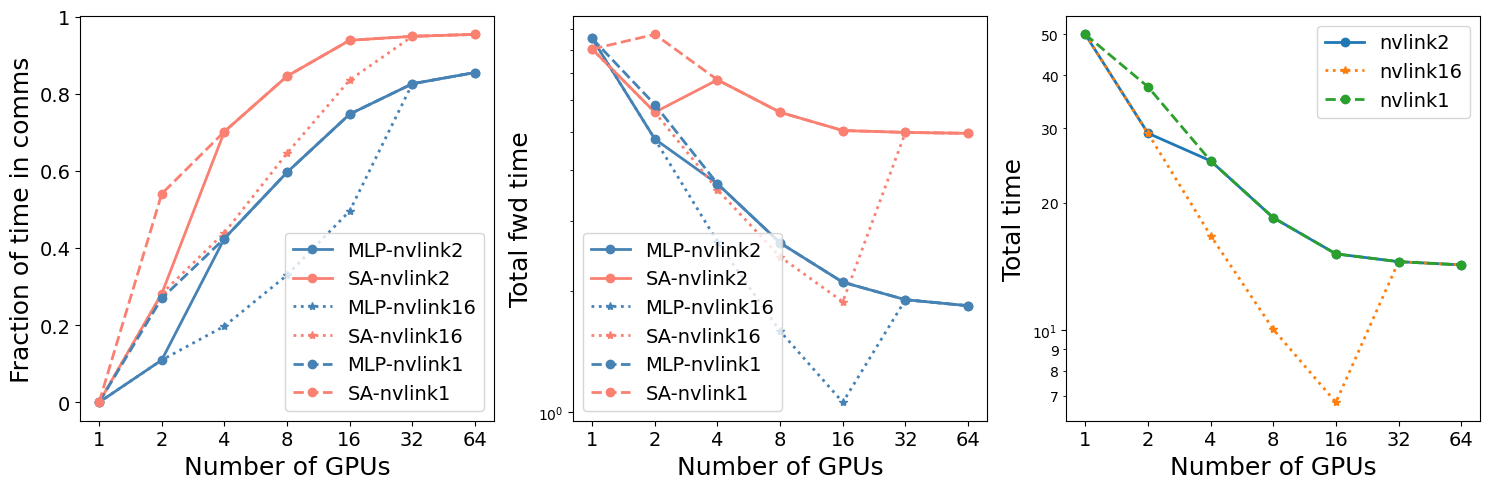

In [8]:
# Sweeps
### model parallelism
n_gpus = [1, 2, 4, 8, 16, 32, 64]
parallelism = {'m1': 1,
               'm2': 1}
system = {'matrix_flops_fp16': 312,
          'vector_flops_fp32': 19.5,
          'vector_flops_fp16': 78,
          'hbm_bandwidth': 1555,
          'nvlink_bandwidth': 300,
          'ib_bandwidth': 100,
          'nvlink_size': 8}

fig, axs = plt.subplots(1,3,figsize=(15,5), tight_layout=True) 
c1 = 'steelblue'
c2 = 'salmon'
fsz = 18

nvs = 2
system['nvlink_size'] = nvs
lgnd = ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot = ["nvlink{}".format(nvs)]
plot(n_gpus, parallelism, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o-")
nvs = 16
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot(n_gpus, parallelism, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="*:")
system['nvlink_size'] = 1
lgnd += ["MLP-nvlink1", "SA-nvlink1"]
lgnd_tot += ["nvlink1"]
plot(n_gpus, parallelism, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o--")